# DBTL 4 data analysis

This notebook analyzes OD340 and OD600 data from DBTL cycle 1 of a flaviolin producing P. putida.

## Inputs and outputs

#### Required file to run this notebook:
   - edd slug


#### File generated by running this notebook:
   
 
    
The files are stored in the user defined directory.

## Setup

Importing needed libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

import edd_utils as eddu

### User parameters

In [2]:
CYCLE = 4

user_params = {
    'output_file_path': f'../data/flaviolin/DBTL{CYCLE}', # Folder for output files,
    'study_slug': 'combinatorial-media-for-flaviolin-dbtl-4',
    'edd_server': 'edd.jbei.org',
    'username': 'tradivojevic',
    } 

In [3]:
study_slug = user_params['study_slug']
edd_server = user_params['edd_server']
username = user_params['username']

## Load the study

In [4]:
try:
  session = eddu.login(edd_server=edd_server, user=username)
except:
  print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
  print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ··············


OK! Connection to EDD successful. We will try to load data from EDD...


In [5]:
df: pd.DataFrame
    
try:
    df = eddu.export_study(session, study_slug, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    try:
        df = pd.read_csv(user_params['study_file'])
    except:
        print(f'ERROR! Alternative loading of data from disk failed!')
    else:
        print(f'OK! Alternative loading of data from disk was successful.')


  0%|          | 0/96 [00:00<?, ?it/s]

In [6]:
df.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,150132,Combinatorial media for flaviolin DBTL 4,150133,C4_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150181,C4_WA1_C1-R1,NaN,Optical Density,0,NaN,0.4093,48.0
1,150132,Combinatorial media for flaviolin DBTL 4,150134,C4_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150182,C4_WA1_C1-R2,NaN,Optical Density,0,NaN,0.3716,48.0
2,150132,Combinatorial media for flaviolin DBTL 4,150135,C4_WA1_C1-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150183,C4_WA1_C1-R3,NaN,Optical Density,0,NaN,0.4587,48.0
3,150132,Combinatorial media for flaviolin DBTL 4,150136,C4_WD1_F1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150184,C4_WD1_F1-R1,NaN,Optical Density,0,NaN,0.3916,48.0
4,150132,Combinatorial media for flaviolin DBTL 4,150137,C4_WD1_F1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150185,C4_WD1_F1-R2,NaN,Optical Density,0,NaN,0.4941,48.0


Drop unnecessary columns:

In [7]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.head()

,Line Name,Line Description,Protocol,Value
0,C4_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4093
1,C4_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3716
2,C4_WA1_C1-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4587
3,C4_WD1_F1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3916
4,C4_WD1_F1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4941


In [8]:
find_col = lambda x: x['Line Name'][5]

def find_row(row):
    line_name = row['Line Name']
    if line_name[4] == 'A':
        if int(line_name[-1]) == 1:
            return "A"
        elif int(line_name[-1]) == 2:
            return "B"
        else:
            return "C"
    else:
        if int(line_name[-1]) == 1:
            return "D"
        elif int(line_name[-1]) == 2:
            return "E"
        else:
            return "F"


In [9]:
df['Row'] =  df.apply(find_row, axis=1)
df['Column'] =  df.apply(find_col, axis=1)


In [10]:
df.head(2)

,Line Name,Line Description,Protocol,Value,Row,Column
0,C4_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4093,A,1
1,C4_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3716,B,1


## Coefficient of variation

In [11]:
df_red = df.drop(columns=['Column'])
stats = df_red.groupby(['Protocol', 'Line Description']).mean()
stats.rename(columns={'Value': 'mean'}, inplace=True)
stats['std'] = df_red.groupby(['Protocol', 'Line Description']).std()
stats['CV[%]'] = 100* stats['std'] / stats['mean']
stats

mean  \
Protocol Line Description                                               
OD340    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.510567   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.461000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.455833   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.560133   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.281333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.459733   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.567467   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.454133   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.359367   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.535967   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.413200   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.477933   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.576167   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.455133   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.476300   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.464867   
OD600    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.832333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  1.109333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  1.170667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.975667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  1.003000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.946333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  1.021667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.886000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.936667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  6.110333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  1.102000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.968667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  1.079667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.939667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  1.148000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.560667   

                                                                  std  \
Protocol Line Description                                               
OD340    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.023399   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.013318   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.055967   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.017029   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.006200   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.039229   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.019860   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.040058   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.024255   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.030491   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.043681   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.014180   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.010312   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.014023   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.040268   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.035491   
OD600    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.138457   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.142732   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.140051   
         MOPS: 40.000000, Tricine: 4.000000, H3BO

## Visualization

/usr/local/share/jupyteruser/miniconda3/envs/ART_3.9.4/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 43.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


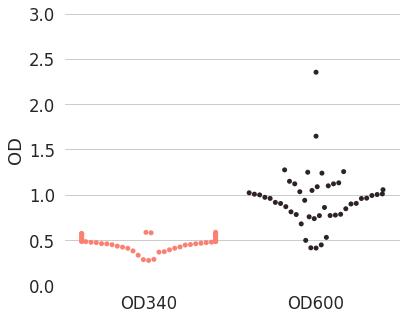

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))
fontsize = 16
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.swarmplot(data=df, 
              linewidth=0,
              x='Protocol',
              y='Value',
              palette="dark:salmon_r"
              )
sns.despine(left=True, bottom=True)
ax.set(xlabel=None, ylabel="OD")

ax.set(ylim=(0,3.))

fig.savefig(
    f"{user_params['output_file_path']}/swarm_both.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

Per line:

In [14]:
line_names = []
df_340 = df[df['Protocol']=='OD340'].reset_index()
for i in range(int(len(df_340)/3)):
    line_names.append(str(df_340['Line Name'][3*i])[3:-3])
# line_names

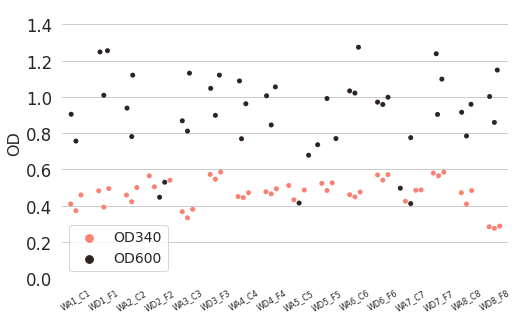

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
fontsize = 14
sns.set_style("whitegrid")
g = sns.swarmplot(data=df, 
              linewidth=0,
              x='Line Description',
              y='Value',
              hue='Protocol',
              palette="dark:salmon_r"
              )
g.set_xticklabels(line_names, fontsize=8, rotation = 30)
plt.legend(fontsize=fontsize)
sns.despine(left=True, bottom=True)
ax.set_ylabel("OD", fontsize=fontsize+2)
ax.set_xlabel(None)
plt.ylim([0, 1.5])

fig.savefig(
    f"{user_params['output_file_path']}/swarm_per_design.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

### Plot OD measurements per well

In [16]:
data_od600 = df[df['Protocol']=='OD600'].pivot('Row', 'Column')['Value']
data_od340 = df[df['Protocol']=='OD340'].pivot('Row', 'Column')['Value']

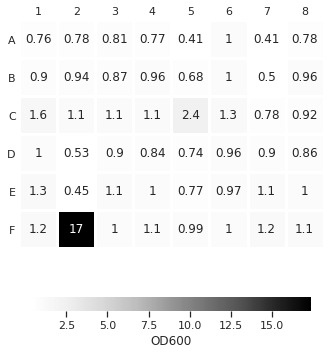

In [17]:
fig = plt.figure(figsize=(10,6))
sns.set(font_scale = 1)
ax = sns.heatmap(data=data_od600, 
                 linewidths=3, 
                 linecolor="w",
                 square= True,
                 cmap="Greys", #Greys, YlGn
                 cbar_kws={"orientation": "horizontal",
                           "shrink": 0.5,
                           'label': 'OD600'
                          },
                 annot = True,
                )
ax.set(xlabel=None, ylabel=None)
plt.yticks(rotation = 0)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
fig.savefig(
    f"{user_params['output_file_path']}/OD600.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

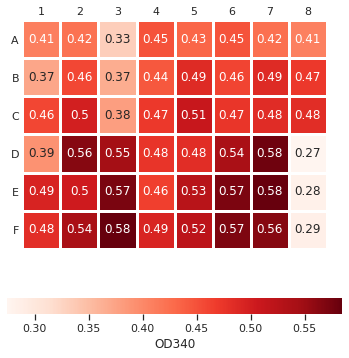

In [18]:
fig = plt.figure(figsize=(10,6))
colormap = sns.color_palette("light:salmon", as_cmap=True)
colormap = "Reds"
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 2.5})
ax = sns.heatmap(data_od340, 
                 linewidths=3, 
                 linecolor="w",
                 square= True,
                 cmap=colormap,
                 cbar_kws={"orientation": "horizontal",
                           "shrink": 0.6,
                           'label': 'OD340'
                          },
                 annot = True,
                )
ax.set(xlabel=None, ylabel=None)
plt.yticks(rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
fig.savefig(
    f"{user_params['output_file_path']}/OD340.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

Load training data and predictions for recommendations:

In [19]:
user_params['target_designs'] = f'../data/flaviolin/DBTL{CYCLE}/target_concentrations.csv'

In [20]:
designs_pred = pd.read_csv(user_params['target_designs'], index_col=0).reset_index()
designs_pred.drop(columns='Well', inplace=True)
designs_pred['OD340'] = df[df['Protocol']=='OD340']['Value'].values
designs_pred.head()

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label,OD340
0,0.024773,0.700826,4.062760,0.047732,12.929126,2.133702,414.274311,0.000250,0.001827,0.000484,0.004128,0.000014,0.578698,0.048176,exploitation,0.4093
1,0.024773,0.700826,4.062760,0.047732,12.929126,2.133702,414.274311,0.000250,0.001827,0.000484,0.004128,0.000014,0.578698,0.048176,exploitation,0.3716
2,0.024773,0.700826,4.062760,0.047732,12.929126,2.133702,414.274311,0.000250,0.001827,0.000484,0.004128,0.000014,0.578698,0.048176,exploitation,0.4587
3,0.000956,2.184192,3.440721,0.091458,10.338878,2.814993,415.796644,0.000265,0.000290,0.000688,0.002765,0.000014,0.513430,0.048443,exploitation,0.3916
4,0.000956,2.184192,3.440721,0.091458,10.338878,2.814993,415.796644,0.000265,0.000290,0.000688,0.002765,0.000014,0.513430,0.048443,exploitation,0.4941


In [21]:
user_params['train_data'] = f'../data/flaviolin/DBTL{CYCLE}/train_pred.csv'

In [22]:
train_pred = pd.read_csv(user_params['train_data'], index_col=0)
train_pred

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.4422,0.369218,0.047605,0.427238,0.049997,train
1,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3405,0.369218,0.047605,0.427238,0.049997,train
2,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3397,0.369218,0.047605,0.427238,0.049997,train
3,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3602,0.369218,0.047605,0.427238,0.049997,train
4,0.009185,0.380499,1.156774,0.007971,11.618192,5.030266,50.607910,0.000155,0.000152,0.000029,0.000410,0.000277,0.2699,0.276460,0.047611,0.250693,0.052678,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.006221,0.150431,6.409492,0.071740,7.294398,1.092270,384.376373,0.000290,0.002585,0.000905,0.002880,0.000835,0.5415,0.535413,0.047618,0.565205,0.054754,train
140,0.006221,0.150431,6.409492,0.071740,7.294398,1.092270,384.376373,0.000290,0.002585,0.000905,0.002880,0.000835,0.5294,0.535413,0.047618,0.565205,0.054754,train
141,0.003709,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098,0.2813,0.284243,0.047602,0.286457,0.044353,standard
142,0.003709,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098,0.2755,0.284243,0.047602,0.286457,0.044353,standard


In [23]:
from sklearn.metrics import r2_score

def predictions_vs_observations(
    designs,
    train,
    errorbars_flag=False,
    xlim=None,
    ylim=None,
):
    
    plt.style.use("seaborn-white")

    fontsize = 20

    fig, ax = plt.subplots(figsize=(7, 7))
    
    obs_all = np.append(train['OD340'], designs['OD340'])
    pred_all = np.append(train['OD340_cv_pred'], designs['OD340_pred'])
    pred_std_all = np.append(train['OD340_cv_std'], designs['OD340_std'])
    
    # Plot Scatter Plot
    if errorbars_flag:
        plt.errorbar(
            obs_all,
            pred_all,
            yerr=1.96 * pred_std_all,
            fmt='none',
            ecolor="lightgray",
            elinewidth=1,
            alpha=0.5,
            zorder=0
        )
            
    plt.scatter(
        train['OD340'], 
        train['OD340_cv_pred'], 
        color="gray",
        label='train'
    )

    standard = train[train['Label']=='standard']
    plt.scatter(
        standard['OD340'], 
        standard['OD340_cv_pred'],
        label='standard',
        color="k"
    )
    
    standard_des = designs[designs['Label']=='standard']
    plt.scatter(standard_des['OD340'], standard_des['OD340_pred'], color="k")
    
    explor_des = designs[designs['Label']=='exploration']
    plt.scatter(
        explor_des['OD340'], 
        explor_des['OD340_pred'], 
        color="orange",
        label='exploration'
    )
    
    exploit_des = designs[designs['Label']=='exploitation']
    plt.scatter(
        exploit_des['OD340'], 
        exploit_des['OD340_pred'], 
        color="r",
        label='exploitation'
    )
    
    r2_train = round(r2_score(train['OD340'], train['OD340_cv_pred']), 2)
    
    r2_all = round(r2_score(obs_all, pred_all), 2)

    ax.set_title(f"$R^2$={r2_train}", fontsize=fontsize)
    ax.set_xlabel("Observations", fontsize=fontsize)
    ax.set_ylabel("Cross-validation predictions", fontsize=fontsize)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    if xlim is None:
        ax.set_xlim(lims)
    else:
        ax.set_xlim(xlim)

    if ylim is None:
        ax.set_ylim(lims)
    else:
        ax.set_ylim(ylim)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    
    plt.legend(loc='best', 
#                shadow=False, 
               fontsize=fontsize-4)

    plt.tick_params(axis="both", which="major", labelsize=fontsize)
    plt.show()

    fig.savefig(
        user_params['output_file_path']
        + "/predictions_vs_observations.png",
        bbox_inches="tight",
        transparent=False,
        dpi=300,
    )

    plt.close(fig)

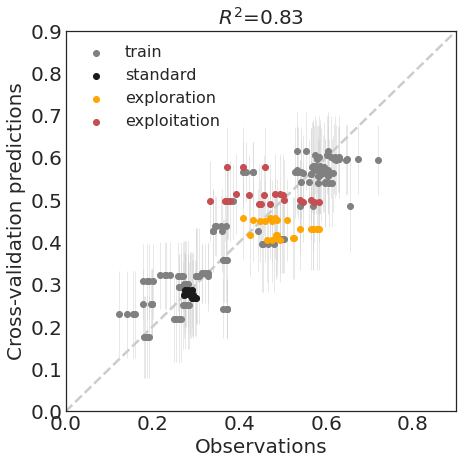

In [24]:
predictions_vs_observations(
    designs=designs_pred,
    train=train_pred,
    errorbars_flag=True,
    xlim=[0., 0.9],
    ylim=[0., 0.9],
)